### Make the LVAE model

In [1]:
import os
import glob
import random
import math
import time
import datetime
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torch.nn import init
from torch.optim.optimizer import Optimizer
from torch.cuda.amp import GradScaler
from tqdm import tqdm
from boilerplate import boilerplate
from models.lvae import LadderVAE
import lib.utils as utils
import sys

In [9]:

import numpy as np
import torch
from tifffile import imread
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
from tifffile import imread
from matplotlib import pyplot as plt

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model_LVAE = torch.load("./Trained_Models/NL[5]zD[32]bpl[3]len_nF[6]lh[GaussianLikelihood_HDN]Stoc[True]lvClip[None]_lvtp[None]_DO_[True]_BN_[True]/model/TalleyLines_best_vae.net")
model_LVAE.mode_pred=True
model_LVAE.stochastic=False
model_LVAE.dropout=0.0
model_LVAE.batchnorm=False
model_LVAE.eval()
print("LVAE Trained Model loaded")

LVAE Trained Model loaded


### Make the Diffusion Model

### From the Test Image set get the latents using LVAE

Text(0.5, 1.0, 'Image T=7 Input')

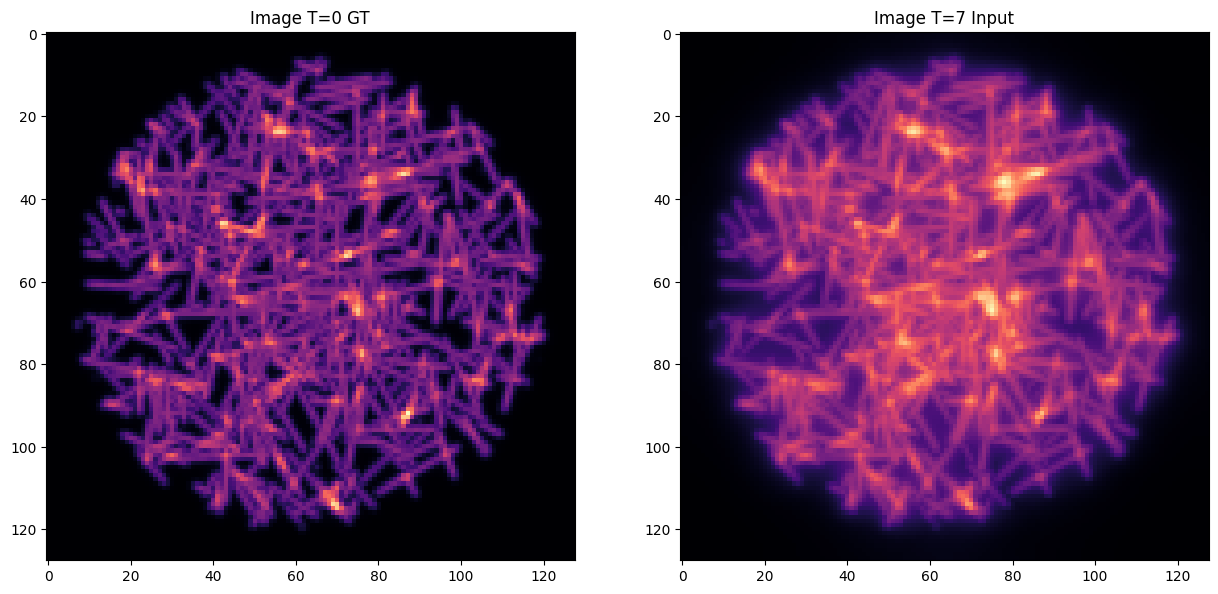

In [10]:
from tifffile import imread
path = "/group/jug/Anirban/Datasets/TalleySim_1024/test/confocal_au_3000.tif"
signal = imread(path)[7:8,...].astype("float32")
image_0 = imread(path)[0:1,...].astype("float32")
#plot gt and signal in the same figure
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(image_0[0,...],cmap="magma")
plt.title("Image T=0 GT")
plt.subplot(1,2,2)
plt.imshow(signal[0,...],cmap="magma")
plt.title("Image T=7 Input")

Text(0.5, 1.0, 'Image T=7 Input')

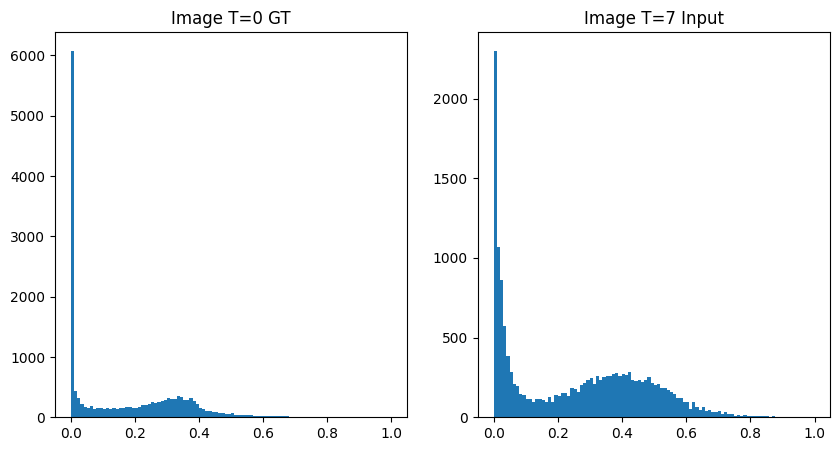

In [4]:
#plot the histogram of the signal and the image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(image_0[0,...].flatten(),bins=100)
plt.title("Image T=0 GT")
plt.subplot(1,2,2)
plt.hist(signal[0,...].flatten(),bins=100)
plt.title("Image T=7 Input")    

Get Z values from LVAE, convert them into clean using R()

In [11]:
print(model_LVAE.mode_pred)

True


-0.031162493 1.0937392


Text(0.5, 1.0, 'Image T=0 GT')

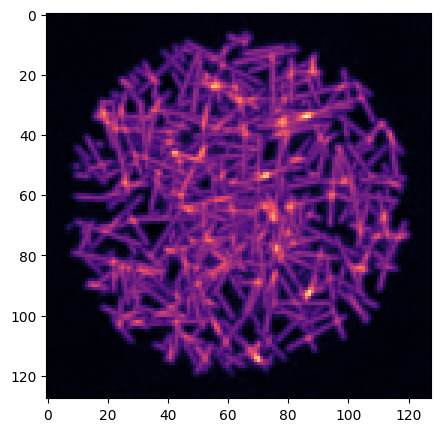

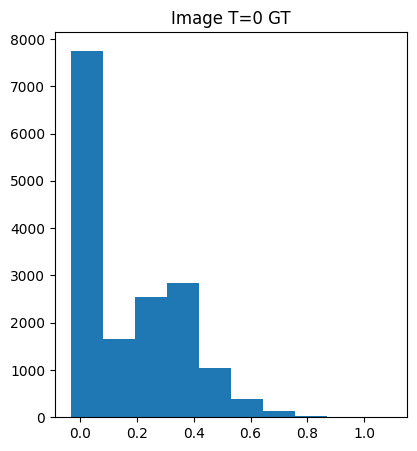

In [12]:
input = torch.from_numpy(np.expand_dims(signal,0)).cuda()
y = torch.from_numpy(np.expand_dims(signal,0)).cuda()
out = model_LVAE(input,y)
img = out['out_img'].detach().cpu().numpy()[0,0,...]
plt.figure(figsize=(5, 5))
plt.imshow(img,cmap='magma')
print(img.min(),img.max())

#plot a histogram of the output
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(img.flatten(),bins=10)
plt.title("Image T=0 GT")

### Compute PSNRs

signal shape:  torch.Size([1, 128, 128])
image_0 shape:  torch.Size([1, 128, 128])
img shape:  torch.Size([1, 128, 128])


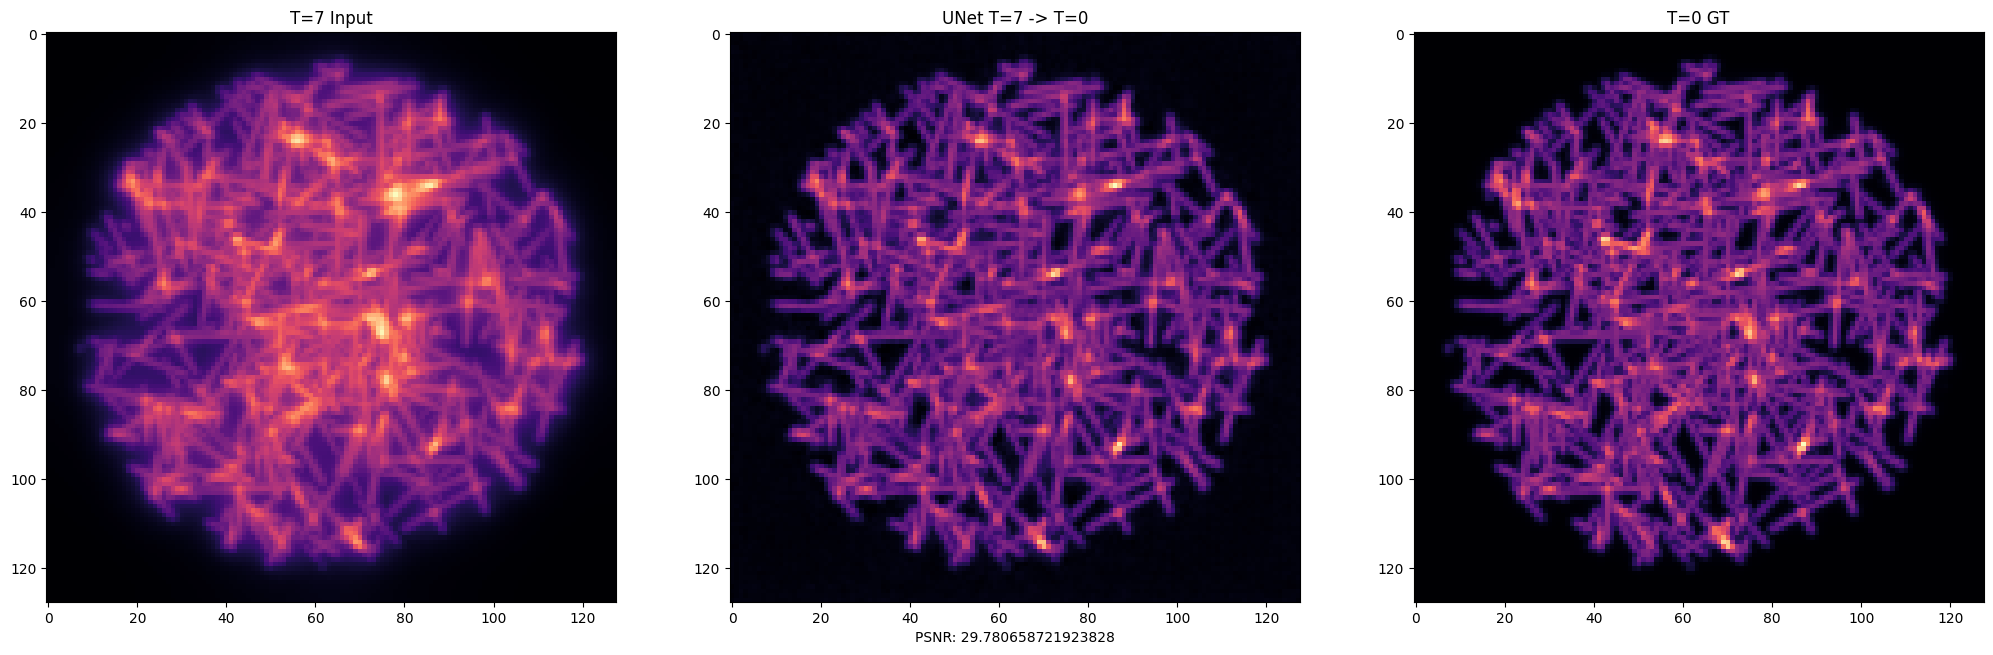

BRISQUE Score:  10.857231440144773


In [13]:
from ra_psnr import RangeInvariantPsnr as PSNR
from brisque import BRISQUE

#convert all the images to torch tensors
signal = torch.Tensor(signal)
image_0 = torch.Tensor(image_0)
img = torch.Tensor(img)
img = img.unsqueeze(0)

print('signal shape: ', signal.shape)
print('image_0 shape: ', image_0.shape)
print('img shape: ', img.shape)

#compute the PSNR
psnr_unet = PSNR(image_0, img)

#plot the images in a grid
fig, ax = plt.subplots(1, 3, figsize=(25, 25))
ax[0].imshow(signal[0], cmap='magma')
ax[0].set_title('T=7 Input')

ax[1].imshow(img[0], cmap='magma')
ax[1].set_title('UNet T=7 -> T=0')
ax[1].set_xlabel('PSNR: ' + str(psnr_unet.item()))


ax[2].imshow(image_0[0], cmap='magma')
ax[2].set_title('T=0 GT')
plt.show()
out_new_3 = np.repeat(img,3,axis=0)
out_new_3 = np.transpose(out_new_3,(1,2,0))
obj = BRISQUE(url=False)
bri_out = obj.score(out_new_3)
print("BRISQUE Score: ",bri_out)

### MMSE of 100 samples

In [14]:
#read all the images in the folder
path = "/group/jug/Anirban/Datasets/TalleySim_1024/test/"
files = glob.glob(path+"/*.tif")
files.sort()
psnrs = 0
for file in files:
    input = imread(file)[7:8,...].astype("float32")
    target = imread(file)[0:1,...].astype("float32")
    input = torch.from_numpy(np.expand_dims(input,0)).cuda()
    y = input
    #do it 10 times
    outs = []
    for i in range(10):
        out = model_LVAE(input,y)
        img = out['out_img'].detach().cpu().numpy()[0,0,...]
        outs.append(img)
    #make outs a torch tensor
    outs = torch.Tensor(outs)
    mean_out = torch.mean(outs,dim=0)
    #compute the PSNR
    psnr_unet = PSNR(torch.Tensor(target), mean_out)
    psnrs += psnr_unet.item()
    print("PSNR: ",psnr_unet.item())
print("Mean PSNR: ",psnrs/len(files))

PSNR:  30.043071746826172
PSNR:  31.68590545654297
PSNR:  30.37914276123047
PSNR:  31.38597869873047
PSNR:  30.985689163208008
PSNR:  31.825450897216797
PSNR:  30.172922134399414
PSNR:  30.649505615234375
PSNR:  31.264293670654297
PSNR:  30.82338523864746
PSNR:  30.29872703552246
PSNR:  29.846384048461914
PSNR:  30.516563415527344
PSNR:  30.586772918701172
PSNR:  30.563718795776367
PSNR:  31.448768615722656
PSNR:  31.37790298461914
PSNR:  29.8060245513916
PSNR:  31.902544021606445
PSNR:  30.76786994934082
PSNR:  30.654935836791992
PSNR:  32.546051025390625
PSNR:  29.57863998413086
PSNR:  30.479969024658203
PSNR:  29.82609748840332
PSNR:  29.912872314453125
PSNR:  32.00138854980469
PSNR:  31.919267654418945
PSNR:  29.075275421142578
PSNR:  30.060688018798828
PSNR:  30.755369186401367
PSNR:  32.96156311035156
PSNR:  31.195833206176758
PSNR:  31.479310989379883
PSNR:  32.26576614379883
PSNR:  30.78696060180664
PSNR:  29.56454086303711
PSNR:  30.118694305419922
PSNR:  30.332805633544922
PS